In [1]:
!pip install pyts
#!pip install shap

### Customized implementation of ST from pyts

In [112]:
"""Code for Shapelet transform algorithm."""

from itertools import chain
from joblib import delayed, Parallel
from numba import njit, prange
from numba.typed import List
import numpy as np
from numpy.lib.stride_tricks import as_strided
from sklearn.base import BaseEstimator
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.utils.validation import (check_array, check_is_fitted,
                                      check_random_state, check_X_y)




class UnivariateTransformerMixin:
    """Mixin class for all univariate transformers in pyts."""

    def fit_transform(self, X, y=None, **fit_params):
        """Fit to data, then transform it.
        Fits transformer to `X` and `y` with optional parameters `fit_params`
        and returns a transformed version of `X`.
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_timestamps)
            Univariate time series.
        y : None or array-like, shape = (n_samples,) (default = None)
            Target values (None for unsupervised transformations).
        **fit_params : dict
            Additional fit parameters.
        Returns
        -------
        X_new : array
            Transformed array.
        """  # noqa: E501
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

@njit()
def _windowed_view(X, n_samples, n_timestamps, window_size, window_step):
    overlap = window_size - window_step
    shape_new = (n_samples,
                 (n_timestamps - overlap) // window_step,
                 window_size // 1)
    s0, s1 = X.strides
    strides_new = (s0, window_step * s1, s1)

    return as_strided(X, shape=shape_new, strides=strides_new)

@njit()
def _extract_all_shapelets(x, window_sizes, window_steps, n_timestamps):
    """Extract all the shapelets from a single time series."""
    shapelets = List()  # shapelets
    lengths = List()  # lengths of shapelets
    start_idx = List()  # start index of shapelets (included)
    end_idx = List()  # end index of shapelets (excluded)

    for window_size, window_step in zip(window_sizes, window_steps):
        # Derive the new shape and strides
        overlap = window_size - window_step
        shape_new = ((n_timestamps - overlap) // window_step, window_size // 1)
        strides = x.strides[0]
        strides_new = (window_step * strides, strides)

        # Derive strided view of x
        x_strided = as_strided(x, shape=shape_new, strides=strides_new)
        x_strided = np.copy(x_strided)

        # Add shapelets, lengths, start indices and end indices
        shapelets.append(x_strided)
        lengths.append([x_strided.shape[1]] * x_strided.shape[0])
        start_idx.append(np.arange(0, n_timestamps - window_size + 1,
                                   window_step))
        end_idx.append(np.arange(window_size, n_timestamps + 1, window_step))

    return shapelets, lengths, start_idx, end_idx



@njit()
def _derive_shapelet_distances(X, shapelet):
    """Derive the distance between a shapelet and all the time series."""
    n_samples, n_windows, _ = X.shape
    #print(n_samples, n_windows)
    mean = np.empty((n_samples, n_windows))
    #add position
    for i in prange(n_samples):
        for j in prange(n_windows):
            mean[i, j] = np.mean((X[i, j] - shapelet) ** 2)
    dist = np.empty(n_samples)
    pos = np.empty(n_samples)
    for i in prange(n_samples):
        dist[i] = np.min(mean[i])
        pos[i] = np.argmin(mean[i])

    #print(dist.shape,pos.shape)
    return dist, pos

@njit
def _derive_transformed_tss(x,pos,shapelet):
    transformed_tss = []
    for i in prange(len(pos)):
          #print(p, shapelet.size, p+shapelet.size, x[i].shape)
          trf_ts = x[i].copy()
          trf_ts[int(pos[i]): int(pos[i]) + int(len(shapelet))] = shapelet
          transformed_tss.append(trf_ts)
    return transformed_tss



@njit()
def _derive_all_squared_distances_fit(
    x, X, n_samples, n_timestamps, window_sizes, shapelets, lengths
):
    """Derive the squared distances between all shapelets and time series."""
    distances = []  # save the distances in a list
    positions = []
    all_transformed_timeseries = []
    for i in prange(len(lengths)):
        window_size = lengths[i][0]
        X_window = _windowed_view(X, n_samples, n_timestamps,
                                  window_size, window_step=1)

        for j in prange(shapelets[i].shape[0]):
            dist, pos  = _derive_shapelet_distances(X_window, shapelets[i][j])
            trf_tss = _derive_transformed_tss(X,pos,shapelets[i][j])
            distances.append(dist)
            positions.append(pos)
            all_transformed_timeseries.append(trf_tss)

    return distances, positions, all_transformed_timeseries


@njit()
def _derive_all_squared_distances_transform(
    x, X, n_samples, n_timestamps, window_sizes, shapelets, lengths
):
    """Derive the squared distances between all shapelets and time series."""
    distances = []  # save the distances in a list
    positions = []
    all_trf_tss = []
    permutation = []  # save the permutation of the indices

    for shapelet, window_size in zip(shapelets, window_sizes):
        X_window = _windowed_view(
            X, n_samples, n_timestamps, window_size, window_step=1
        )
        indices = np.where(lengths == window_size)[0]
        permutation.append(indices)

        for idx in indices:
            dist, pos, trf_tss = _derive_shapelet_distances(n_samples, X_window, shapelets[idx])
            distances.append(dist)
            positions.append(pos)
            all_trf_tss.append(trf_tss)
    return distances, positions, permutation, all_trf_tss


def _derive_all_distances(x, X, window_sizes, shapelets, lengths, fit):
    """Derive the distances between all the shapelets and the time series."""
    n_samples, n_timestamps = X.shape
    if fit:
        distances, positions, timeseries = _derive_all_squared_distances_fit(
            x,X, n_samples, n_timestamps, window_sizes, shapelets, lengths
        )
        #print(np.sqrt(np.asarray(distances)).T.shape, np.asarray(positions).T.shape,np.asarray(positions).T )
        return np.sqrt(np.asarray(distances)).T ,np.asarray(positions).T, np.asarray(timeseries).T
    else:
        distances, positions, permutation = _derive_all_squared_distances_transform(
            X, n_samples, n_timestamps, window_sizes, shapelets, lengths
        )
        # Compute the inverse permutation of the indices
        permutation = np.concatenate(permutation)
        inverse_perm = np.arange(permutation.size)[np.argsort(permutation)]
        #print(np.sqrt(np.asarray(positions))[inverse_perm].T)
        return np.sqrt(np.asarray(distances))[inverse_perm].T, np.asarray(positions).T


@njit()
def _remove_similar_shapelets(scores, start_idx, end_idx):
    """Remove self-similar shapelets."""

    kept_idx = []
    remaining_idx = np.full(scores.size, True)

    # Sort the indices by scores
    argsorted_scores = np.argsort(scores)
    sorted_start_idx = start_idx[argsorted_scores]
    sorted_end_idx = end_idx[argsorted_scores]

    # While there are non-similar shapelets remaining
    while np.any(remaining_idx):
        idx = argsorted_scores[remaining_idx][-1]  # Find the best shapelet
        kept_idx.append(idx)

        start, end = start_idx[idx], end_idx[idx]  # Find start and end indices

        # Find non-similar shapelets
        remaining_idx = np.logical_and(
            np.logical_or(sorted_start_idx >= end, sorted_end_idx <= start),
            remaining_idx
        )

    return np.array(kept_idx)


class ShapeletTransform(BaseEstimator, UnivariateTransformerMixin):
    """Shapelet Transform Algorithm.

    The Shapelet Transform algorithm extracts the most discriminative
    shapelets from a data set of time series. A shapelet is defined as
    a subset of consecutive points from a time series. Two criteria are
    made available: mutual information and F-scores.

    Parameters
    ----------
    n_shapelets : int or 'auto' (default = 'auto')
        The number of shapelets to keep. If 'auto', `n_timestamps // 2`
        shapelets are considered, where `n_timestamps` is the number of
        time points in the dataset. Note that there might be a smaller
        number of shapelets if fewer than ``n_shapelets`` shapelets have been
        extracted during the search.

    criterion : 'mutual_info' or 'anova' (default = 'mutual_info')
        Criterion to perform the selection of the shapelets.
        'mutual_info' uses the mutual information, while 'anova' use
        the ANOVA F-value.

    window_sizes : array-like or 'auto '(default = 'auto')
        Size of the sliding windows. If 'auto', the range for the
        window sizes is determined automatically.
        Otherwise, all the elements must be either integers or floats.
        In the latter case, each element represents the percentage
        of the size of each time series and must be between 0 and 1; the size
        of the sliding windows will be computed as
        ``np.ceil(window_sizes * n_timestamps)``.

    window_steps : None or array-like (default = None)
        Step of the sliding windows. If None, each ``window_step`` is equal
        to 1. Otherwise, all the elements must be either integers or floats.
        In the latter case, each element represents the percentage of the size
        of each time series and must be between 0 and 1; the step of the
        sliding windows will be computed as
        ``np.ceil(window_steps * n_timestamps)``.
        Must be None if ``window_sizes='auto'``.

    remove_similar : bool (default = True)
        If True, self-similar shapelets are removed, keeping only
        the non-self-similar shapelets with the highest scores. Two
        shapelets are considered to be self-similar if they are
        taken from the the same time series and have at least one
        overlapping index.

    sort : bool (default = False)
        If True, shapelets are sorted in descending order according to
        their associated scores. If False, the order is undefined.

    verbose : int (default = 0)
        Verbosity level when fitting: if non zero, progress messages are
        printed. Above 50, the output is sent to stdout.
        The frequency of the messages increases with the verbosity level.

    random_state : int, RandomState instance or None (default = None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by ``np.random``. Only used if ``window_sizes='auto'`` in order to
        subsample the dataset to find the best range or if
        ``criterion=='mutual_info'`` to add small noise to the data.

    n_jobs : None or int (default = None)
        The number of jobs to run in parallel for ``fit``.
        If -1, then the number of jobs is set to the number of cores.

    Attributes
    ----------
    shapelets_ : array, shape = (n_shapelets,)
        The array with the selected shapelets.

    indices_ : array, shape = (n_shapelets, 3)
        The indices for the corresponding shapelets in the training set.
        The first column consists of the indices of the samples.
        The second column consists of the starting indices (included)
        of the shapelets. The third column consists of the ending indices
        (excluded) of the shapelets.

    scores_ : array, shape = (n_shapelets,)
        The scores associated to the shapelets. The higher, the more
        discriminant.
        If ``criterion='mutual_info'``, mutual information scores are reported.
        If ``criterion='anova'``, F-scores are reported.

    window_range_ : None or tuple
        Range of the window sizes if ``window_sizes='auto'``. None otherwise.

    References
    ----------
    .. [1] J. Lines, L. M. Davis, J. Hills and A. Bagnall, "A Shapelet
           Transform for Time Series Classification". Data Mining and Knowledge
           Discovery, 289-297 (2012).

    Examples
    --------
    >>> from pyts.transformation import ShapeletTransform
    >>> X = [[0, 2, 3, 4, 3, 2, 1],
    ...      [0, 1, 3, 4, 3, 4, 5],
    ...      [2, 1, 0, 2, 1, 5, 4],
    ...      [1, 2, 2, 1, 0, 3, 5]]
    >>> y = [0, 0, 1, 1]
    >>> st = ShapeletTransform(n_shapelets=2, window_sizes=[3])
    >>> st.fit(X, y)
    ShapeletTransform(...)
    >>> len(st.shapelets_)
    2
    >>> st.indices_.shape
    (2, 3)

    """

    def __init__(self, model= None, n_shapelets='auto', criterion='mutual_info',
                 window_sizes='auto', window_steps=None,
                 remove_similar=True, sort=False, verbose=0, random_state=None,
                 n_jobs=None):
        self.model = model
        self.n_shapelets = n_shapelets
        self.criterion = criterion
        self.window_sizes = window_sizes
        self.window_steps = window_steps
        self.remove_similar = remove_similar
        self.sort = sort
        self.verbose = verbose
        self.random_state = random_state
        self.n_jobs = n_jobs


    def fit(self, X, y):
        """Fit the model according to the given training data.

        It finds the ``n_shapelets`` best shapelets in the training set.

        Parameters
        ----------
        X : array-like, shape = (n_samples, n_timestamps)
            Univariate time series.

        y : array-like, shape = (n_samples,)
            Class labels for each data sample.

        Returns
        -------
        self : object

        """
        X, y = check_X_y(X, y, dtype='float64')
        (n_shapelets, window_sizes,
         window_steps, n_jobs, rng) = self._check_params(X, y)

        X_new, scores, shapelets, indices, X_pos = self._fit(
            X, y, n_shapelets, window_sizes, window_steps,
            self.remove_similar, n_jobs, rng
        )

        if self.sort:
            idx_sorted = np.argsort(scores)[::-1]
            self.scores_ = scores[idx_sorted]
            self.shapelets_ = shapelets[idx_sorted]
            self.indices_ = indices[idx_sorted]
            self.positions_ = X_pos
        else:
            self.scores_ = scores
            self.shapelets_ = shapelets
            self.indices_ = indices
            self.positions_ = X_pos

        return self


    def transform(self, X):
        """Transform the provided data.

        It computes the distances between the selected shapelets
        and the samples.

        Parameters
        ----------
        X : array-like, shape = (n_samples, n_timestamps)
            Univariate time series.

        Returns
        -------
        X_new : array, shape = (n_samples, n_shapelets)
            Distances between the selected shapelets and the samples.

        """
        check_is_fitted(self, ['shapelets_', 'indices_', 'scores_'])
        X = check_array(X, dtype='float64')
        return self._transform(X)


    def fit_transform(self, X, y):
        """Fit the model than transform the given training data.

        It finds the ``n_shapelets`` best shapelets in the training set
        and computes the distances between them and the training set.

        Parameters
        ----------
        X : array-like, shape = (n_samples, n_timestamps)
            Univariate time series.

        y : array-like, shape = (n_samples,)
            Class labels for each data sample.

        Returns
        -------
        X_new : array, shape = (n_samples, n_shapelets)
            Distances between the selected shapelets and the samples.

        """
        X, y = check_X_y(X, y, dtype='float64')
        (n_shapelets, window_sizes, window_steps,
         n_jobs, rng) = self._check_params(X, y)

        X_new, scores, shapelets, indices, X_pos = self._fit(X, y, n_shapelets, window_sizes, window_steps, self.remove_similar, n_jobs, rng
        )

        if self.sort:
            idx_sorted = np.argsort(scores)[::-1]
            self.scores_ = scores[idx_sorted]
            self.shapelets_ = shapelets[idx_sorted]
            self.indices_ = indices[idx_sorted]
            #self.positions_ = X_pos[:,idx_sorted]
            X_new = X_new[:, idx_sorted]
        else:
            self.scores_ = scores
            self.shapelets_ = shapelets
            self.indices_ = indices
            self.positions_ = X_pos
        return X_new


    def _check_params(self, X, y):
        n_timestamps = X.shape[1]

        # Checking for 'n_shapelets'
        n_shapelets_int = isinstance(self.n_shapelets, (int, np.integer))
        if not (self.n_shapelets == 'auto' or n_shapelets_int):
            raise TypeError("'n_shapelets' must be 'auto' or an integer.")
        if (n_shapelets_int and not self.n_shapelets > 0):
            raise ValueError("If 'n_shapelets' is an integer, it must be a "
                             "positive integer (got {})."
                             .format(self.n_shapelets))

        # Checking for 'criterion'
        if self.criterion not in ('mutual_info', 'anova','custom'):
            raise ValueError("'criterion' must be either 'mutual_info' or "
                             "'anova' (got {}).".format(self.criterion))

        # Checking for 'window_sizes'
        window_sizes_auto = (isinstance(self.window_sizes, str) and
                             self.window_sizes == 'auto')
        window_sizes_array = isinstance(self.window_sizes,
                                        (list, tuple, np.ndarray))
        if not (window_sizes_auto or window_sizes_array):
            raise TypeError("'window_sizes' must be 'auto', a list, a tuple "
                            "or a numpy.ndarray.")
        if window_sizes_array:
            window_sizes = np.asarray(self.window_sizes)
            if window_sizes.ndim != 1:
                raise ValueError("'window_sizes' must be one-dimensional.")
            if not issubclass(window_sizes.dtype.type,
                              (np.integer, np.floating)):
                raise ValueError("The elements of 'window_sizes' must be "
                                 "integers or floats.")
            if issubclass(window_sizes.dtype.type, np.floating):
                if not (np.min(window_sizes) > 0 and
                        np.max(window_sizes) <= 1):
                    raise ValueError(
                        "If the elements of 'window_sizes' are floats, they "
                        "all must be greater than 0 and lower than or equal "
                        "to 1."
                    )
                window_sizes = np.ceil(
                    window_sizes * n_timestamps).astype('int64')
            else:
                if not (np.min(window_sizes) > 0 and
                        np.max(window_sizes) <= n_timestamps):
                    raise ValueError(
                        "If the elements of 'window_sizes' are integers, they "
                        "all must be greater than 0 and lower than or equal "
                        "to n_timestamps."
                    )

        # Checking for 'window_steps'
        if not ((self.window_steps is None)
                or isinstance(self.window_steps, (list, tuple, np.ndarray))):
            raise TypeError("'window_steps' must be None or array-like.")
        if self.window_steps is not None:
            if window_sizes_auto:
                raise ValueError(
                    "'window_steps' must be None if window_sizes='auto'."
                )
            window_steps = np.asarray(self.window_steps)
            if window_steps.ndim != 1:
                raise ValueError("'window_steps' must be one-dimensional.")
            if window_steps.size != window_sizes.size:
                raise ValueError("If 'window_steps' is not None, it must have "
                                 "the same size as 'window_sizes'.")
            if not issubclass(window_steps.dtype.type,
                              (np.integer, np.floating)):
                raise ValueError(
                    "If 'window_steps' is not None, the elements of "
                    "'window_steps' must be integers or floats."
                )
            if issubclass(window_steps.dtype.type, np.floating):
                if not ((np.min(window_steps) > 0
                         and np.max(window_steps) <= 1)):
                    raise ValueError(
                        "If the elements of 'window_steps' are floats, they "
                        "all must be greater than 0 and lower than or equal "
                        "to 1."
                    )
                window_steps = np.ceil(
                    window_steps * n_timestamps).astype('int64')
            else:
                if not ((np.min(window_steps) > 0)
                        and (np.max(window_steps) <= n_timestamps)):
                    raise ValueError(
                        "If the elements of 'window_steps' are integers, they "
                        "all must be greater than 0 and lower than or equal "
                        "to n_timestamps."
                    )

        # Checking for 'verbose'
        if not (isinstance(self.verbose, (int, np.integer))
                and self.verbose >= 0):
            raise ValueError("'verbose' must be a positive integer (got {})."
                             .format(self.verbose))

        # Checking for 'n_jobs'
        if not (self.n_jobs is None or isinstance(self.n_jobs, int)):
            raise TypeError("'n_jobs' must be None or an integer.")

        # Derive 'n_jobs' and 'random_state'
        n_jobs = 1 if self.n_jobs is None else self.n_jobs
        rng = check_random_state(self.random_state)

        # Derive parameter values for 'auto' cases
        if self.n_shapelets == 'auto':
            n_shapelets = X.shape[1] // 2
        else:
            n_shapelets = self.n_shapelets

        if isinstance(self.window_sizes, str):
            if self.window_sizes == 'auto':
                window_sizes = self._auto_length_computation(X, y, rng, n_jobs)
                self.window_range_ = (window_sizes[0], window_sizes[-1])
        else:
            self.window_range_ = None

        if self.window_steps is None:
            window_steps = np.ones_like(window_sizes)

        return n_shapelets, window_sizes, window_steps, n_jobs, rng

    #Added:

    def _embedd_timeseries(self,x,start_array,end_array, lengths,baseline_embedding = 0):
        new_ts_data = []
        #pass
        for starts, ends in zip(start_array, end_array):
            mask = np.zeros_like(x.copy(), dtype=bool)
            for s,e in zip(starts,ends):
              new_vals = x.copy()
              mask[s:e] = True
              new_vals[~mask] = 0
              new_ts_data.append(np.array(new_vals))
        return new_ts_data

    def _custom_score(self,old_x,new_x):
        scores = []
        correct_dims = np.expand_dims(old_x,axis=0)
        #print(np.array(correct_dims).shape,np.array(new_x).shape)
        baseline_acc = self.model.predict_proba(correct_dims)
        ypred_label = np.argmax(baseline_acc)

        for i,onx in enumerate(new_x):
          new_acc = self.model.predict_proba(np.expand_dims(onx,axis=0))
          acc_change = new_acc[0,ypred_label] - baseline_acc[0,ypred_label] / baseline_acc[0,ypred_label]
          scores.append(acc_change)

        return np.array(scores)

    def _custom_score_2(self,x,X,new_x):
        #print("CUSTOM SCORE", X.shape, new_x.T.shape)
        scores = []
        #correct_dims = np.expand_dims(x,axis=0)
        #print(np.array(correct_dims).shape,np.array(new_x).shape)
        #baseline_acc = self.model.predict_proba(correct_dims)
        print(new_x.shape)
        new_x = np.swapaxes(new_x, 0, 2)
        for i in range(new_x.shape[0]):
          for j in range(new_x.shape[1]):
            base_score = self.model.predict_proba(np.expand_dims(X[j],axis=0))[0][0]
            new_score = self.model.predict_proba(np.expand_dims(new_x[i,j],axis=0))[0][0]
            new_score -= base_score
        scores.append(new_score)
        return np.array(scores)
        #print(oldx.shape,newx.shape)


    def _fit_one_time_series(
        self, x, X, y, n_timestamps, n_shapelets, window_sizes,
        window_steps, remove_similar, i, rng, classifier = None
    ):
        """Fit one time series."""
        # Extract all shapelets
        shapelets, lengths, start_idx, end_idx = _extract_all_shapelets(
            x, window_sizes, window_steps, n_timestamps)


        #print(start_idx[0],end_idx[0])#start_idx,end_idx)

        #new_x = self._embedd_timeseries(ts,start_idx,end_idx,lengths)

        # Derive distances between shapelets and time series
        X_dist, X_pos, X_ts = _derive_all_distances(x, X, window_sizes, shapelets, lengths, fit=True)
        #print(X_dist.shape, X_ts.shape, y.shape)
        #print("Xp",X_pos)
        if self.criterion == 'mutual_info':
            scores = mutual_info_classif(X_dist, y, discrete_features=False,
                                         random_state=rng)

            #print("MIscore", scores.shape) score is for each permutation

        elif self.criterion == 'custom':
            #scores = self._custom_score(x,new_x)
            scores = self._custom_score_2(x,X,X_ts)
        else:
            scores, _ = f_classif(X_dist, y)

        # Flatten the list of 2D arrays into an array of 1D arrays
        shapelets = [list(shapelet) for shapelet in shapelets]
        shapelets = np.asarray(list(chain.from_iterable(shapelets)),
                               dtype='object')

        # Concatenate the list/tuple of 1D arrays into one 1D array
        start_idx = np.concatenate(start_idx)
        end_idx = np.concatenate(end_idx)

        # Remove similar shapelets
        if remove_similar:
            idx = _remove_similar_shapelets(scores.copy(), start_idx, end_idx)
            scores = scores[idx]
            shapelets = shapelets[idx]
            start_idx = start_idx[idx]
            end_idx = end_idx[idx]
            #print("Remove",len(shapelets),len(X_dist),len(X_pos), type(shapelets),type(X_dist), type(X_pos))
            X_dist = X_dist[:, idx]
            X_pos = X_pos[:,idx]

        # Keep at most 'n_shapelets'
        if scores.size > n_shapelets - 1:
            idx = np.argpartition(
                scores, scores.size - n_shapelets)[-n_shapelets:]
            scores = scores[idx]
            shapelets = shapelets[idx]
            start_idx = start_idx[idx]
            end_idx = end_idx[idx]
            #print("Retain",len(shapelets),len(X_dist),len(X_pos), type(shapelets),type(X_dist), type(X_pos))

            #print("Retain",len(shapelets),len(X_dist),len(X_pos), type(shapelets),type(X_dist), type(X_pos))
        #print(type(scores))
        time_series_idx = np.full(scores.size, i)
        #print(X_dist.shape, X_pos)
        return X_pos,X_dist, scores, shapelets, start_idx, end_idx, time_series_idx
    def _fit(self, X, y, n_shapelets, window_sizes, window_steps,
             remove_similar, n_jobs, rng):
        """Fit all the time series"""
        n_samples, n_timestamps = X.shape


        """
        res = []
        c = 0
        for i in range(n_samples):
          c+=1
          res.append(self._fit_one_time_series(
                X[i], X, y, n_timestamps, n_shapelets, window_sizes,
                window_steps, remove_similar, i, rng))
          if c>0:break



        print(res[0][0].shape, res[0][1].reshape((50, 6)))

        """
        res = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(self._fit_one_time_series)(
                X[i], X, y, n_timestamps, n_shapelets, window_sizes,
                window_steps, remove_similar, i, rng
            )
            for i in range(n_samples))


        #print(type(res))



        (X_pos,X_dist, scores, shapelets,
         start_idx, end_idx, time_series_idx) = zip(*res)

        #print(type(X_dist), type(X_pos))
        #print("Xd",X_dist)
        #print("Xp",X_pos)
        #print(X_dist.shape, X_pos.shape)
        # Concatenate the results
        X_dist = np.hstack(X_dist)
        X_pos = np.hstack(X_pos)
        #X_pos = X_pos.reshape((50,341))
        #print(X_dist.shape, X_pos.shape)
        scores = np.concatenate(scores)
        shapelets = np.concatenate(shapelets)
        if shapelets.ndim > 1:
            shapelets = shapelets.astype('float64')
        start_idx = np.concatenate(start_idx)
        end_idx = np.concatenate(end_idx)
        time_series_idx = np.concatenate(time_series_idx)

        # Keep at most 'n_shapelets'
        if scores.size > n_shapelets - 1:
            idx = np.argpartition(
                scores, scores.size - n_shapelets)[-n_shapelets:]
            #print("Retain Fit",X_dist.shape,X_pos.shape)
            X_dist = X_dist[:, idx]
            scores = scores[idx]
            shapelets = shapelets[idx]
            start_idx = start_idx[idx]
            end_idx = end_idx[idx]
            time_series_idx = time_series_idx[idx]
            X_pos = X_pos[:,idx]


        # Derive the 'indices' attributes
        indices = np.empty((scores.size, 3), dtype='int64')
        indices[:, 0] = time_series_idx
        indices[:, 1] = start_idx
        indices[:, 2] = end_idx

        return X_dist, scores, shapelets, indices, X_pos

    def _transform(self, X):
        lengths = self.indices_[:, 2] - self.indices_[:, 1]
        window_sizes = np.unique(lengths)

        # Convert the array of arrays of shapelets to a numba.typed.List object
        shapelets_list = List()
        for x in self.shapelets_:
            shapelets_list.append(x.astype('float64'))

        X_new, X_pos = _derive_all_distances(
            X, window_sizes, shapelets_list, lengths, fit=False)
        return X_new, X_pos

    def _auto_length_computation(self, X, y, rng, n_jobs):
        """Derive the window sizes automatically."""
        n_samples, n_timestamps = X.shape
        window_sizes = np.arange(1, n_timestamps + 1)
        window_steps = np.ones_like(window_sizes)

        if n_samples > 10:
            shapelet_lengths = []
            for i in range(10):
                idx = rng.choice(n_samples, size=10, replace=False)
                X_small, y_small = X[idx], y[idx]
                _, _, shapelets, _ = self._fit(
                    X_small, y_small, 10, window_sizes, window_steps,
                    self.remove_similar, n_jobs, rng
                )
                shapelet_lengths.extend(
                    [len(shapelet) for shapelet in shapelets])

            window_range = np.percentile(
                shapelet_lengths, [25, 75], interpolation='lower'
            ).astype('int64')
            window_sizes = np.arange(window_range[0], window_range[1] + 1)

        else:
            _, _, shapelets, _ = self._fit(
                X, y, 100, window_sizes, window_steps,
                self.remove_similar, n_jobs, rng
            )
            shapelet_lengths = [len(shapelet) for shapelet in shapelets]
            window_range = np.percentile(
                shapelet_lengths, [25, 75], interpolation='lower'
            ).astype('int64')
            window_sizes = np.arange(window_range[0], window_range[1] + 1)

        return window_sizes




In [115]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
#from pyts.transformation import ShapeletTransform




# Toy dataset
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

# Shapelet transformation
st = ShapeletTransform(mlp,
                       window_sizes=[36],#[12, 24, 36, 48],
                       random_state=42,
                       n_shapelets=5,
                       sort=False,
                       criterion="custom")

X_new = st.fit_transform(X_train, y_train)

(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)
(150, 50, 115)


### Transformation / Classification

In [ ]:
#!pip install TSInterpret

In [3]:
!pip install tslearn

In [83]:
#help(TSInterpre.Modelst)
from tslearn.neural_network import TimeSeriesMLPClassifier
mlp = TimeSeriesMLPClassifier(hidden_layer_sizes=(64, 64),
                              random_state=0)

In [88]:

from tslearn.datasets import UCR_UEA_datasets
import numpy as np
import sklearn
dataset = 'GunPoint'
x_train,y_train,x_test,y_test=UCR_UEA_datasets().load_dataset(dataset)


nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

# transform the labels from integers to one hot vectors
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

# save orignal y because later we will use binary
y_true = np.argmax(y_test, axis=1)

if len(x_train.shape) == 2:  # if univariate
    # add a dimension to make it multivariate with one dimension
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

input_shape = x_train.shape[1:]


#classifier = CNN.Classifier_CNN("./debug",input_shape,nb_classes )
#classifier.fit(x_train, y_train, x_test, y_test)

x_train = x_train.squeeze(axis=-1)
mlp.fit(x_train,y_train)
#mlp.predict_proba(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


TimeSeriesMLPClassifier(hidden_layer_sizes=(64, 64), random_state=0)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
#from pyts.transformation import ShapeletTransform

# Toy dataset
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

# Shapelet
st = ShapeletTransform(mlp,
                       window_sizes=[36],#[12, 24, 36, 48],
                       random_state=42,
                       n_shapelets=10,
                       sort=False,
                       criterion="custom")

X_new = st.fit_transform(X_train, y_train)



NameError: ignored

In [117]:
st.indices_[:9]

array([[ 7,  0, 36],
       [49,  0, 36],
       [23,  0, 36],
       [38,  0, 36],
       [17,  0, 36]])

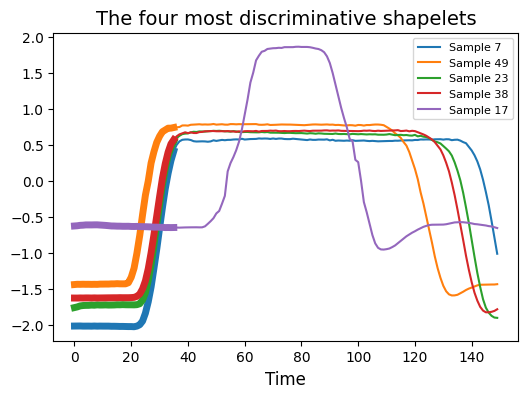

In [116]:
# Visualize the four most discriminative shapelets
plt.figure(figsize=(6, 4))


for i, index in enumerate():
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),
             label='Sample {}'.format(idx))
    plt.plot(np.arange(start, end), X_train[idx, start:end],
             lw=5, color='C{}'.format(i))

plt.xlabel('Time', fontsize=12)
plt.title('The four most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

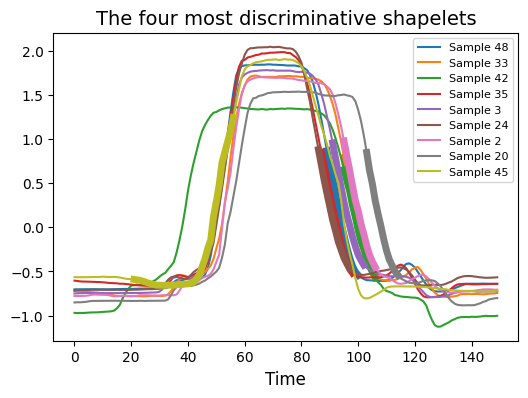

In [ ]:
# Shapelet transformation
st = ShapeletTransform(mlp,
                      window_sizes=[12,36],#[12, 24, 36, 48],
                       random_state=42,
                       n_shapelets=10,
                       sort=False)

X_new = st.fit_transform(X_train, y_train)

# Visualize the four most discriminative shapelets
plt.figure(figsize=(6, 4))

for i, index in enumerate(st.indices_[:9]):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),
             label='Sample {}'.format(idx))
    plt.plot(np.arange(start, end), X_train[idx, start:end],
             lw=5, color='C{}'.format(i))

plt.xlabel('Time', fontsize=12)
plt.title('The four most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rclf = RandomForestClassifier(max_depth=2, random_state=0)

rclf.fit(X_new_1, y_train)
rclf.score(X_new_1,y_train)

0.78

### Random Forest Custom

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rclf = RandomForestClassifier(max_depth=2, random_state=0)
Xt_new = st.transform(X_test)
rclf.fit(X_new,y_train)
print(rclf.score(Xt_new[0],y_test))

0.6066666666666667


In [ ]:
import shap

explainer = shap.TreeExplainer(rclf, X_new)
explanation_obj = explainer(Xt_new[0])

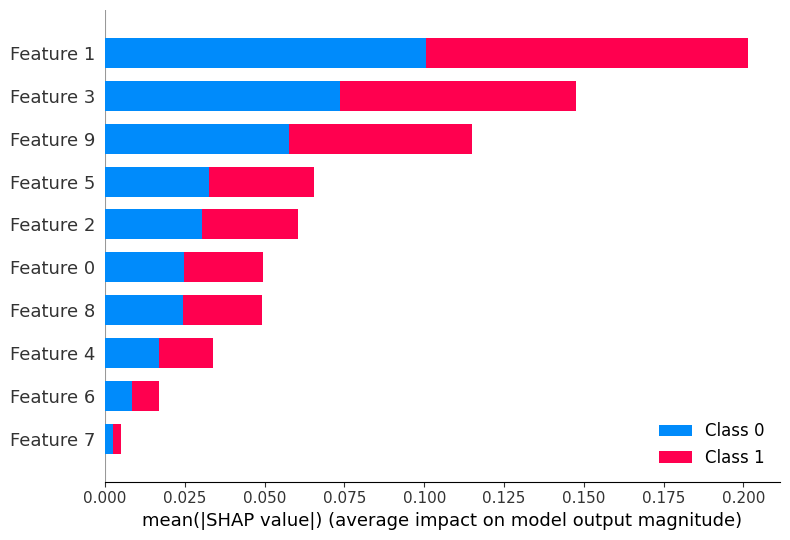

In [ ]:
shap.summary_plot(list(explanation_obj.values.transpose(2,0,1)), X_new, plot_type="bar")

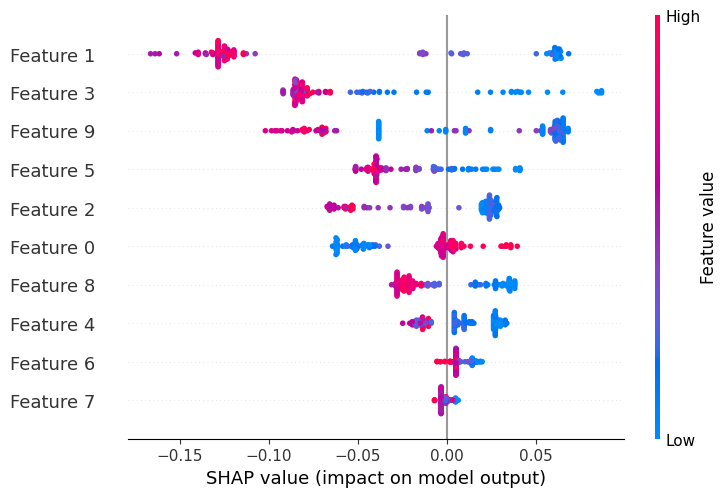

In [ ]:
def explanation_for_class(explanation_obj,yclass):
  shp_vals = explanation_obj.values[:,:,yclass]
  shp_bvals = explanation_obj.base_values[:,yclass]
  data = explanation_obj.data
  return shap.Explanation(shp_vals, base_values=shp_bvals, data=data)

class0 =  explanation_for_class(explanation_obj,0)
shap.plots.beeswarm(class0)